In [ ]:
import pandas as pd
import numpy as np
import pickle

#node2vec model
from gensim.models import Word2Vec

# for graph plotting
import matplotlib.pyplot as plt
import seaborn as sns

import json

# Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#centrality & network features
centrality_network_features = pd.read_csv('/content/drive/My Drive/BT4012 Team 8/Ethereum/Centrality_network_features.csv')
#degree related features
degree_features = pd.read_csv('/content/drive/My Drive/BT4012 Team 8/Ethereum/whole_final_dataset.csv')
#embedding
file_path = '/content/drive/My Drive/BT4012 Team 8/Ethereum/node2vec_embeddings_keys.json'
with open(file_path, 'r') as json_file:
    embedding_key = json.load(json_file)
embedding = np.load('/content/drive/My Drive/BT4012 Team 8/Ethereum/node2vec_embeddings.npy')
# Read the first JSON file
with open('/content/drive/My Drive/BT4012 Team 8/Ethereum/component_characteristics.json', 'r') as component_file:
    component_characteristics = json.load(component_file)
component_characteristics = pd.DataFrame.from_dict(component_characteristics, orient='index')
component_characteristics.index.name = 'component_id'
component_characteristics.reset_index(inplace=True)
# Read the second JSON file
with open('/content/drive/My Drive/BT4012 Team 8/Ethereum/node_component_characteristics.json', 'r') as component_file:
    node_component_characteristics = json.load(component_file)
node_component_characteristics = pd.DataFrame.from_dict(node_component_characteristics, orient='index')
node_component_characteristics.index.name = 'node'
node_component_characteristics.reset_index(inplace=True)
clustering_coefficient = pd.read_csv('/content/drive/My Drive/BT4012 Team 8/Ethereum/clustering_coefficient.csv')

get component_eccentricity to node_characteristics

In [ ]:
# Initialize an empty DataFrame to store the flattened eccentricity values
eccentricity_dict = pd.DataFrame()

# Iterate through the DataFrame containing dictionaries
for index, row in component_characteristics.iterrows():
    component_eccentricity = pd.DataFrame(row['component_eccentricity'], index=[0]).T
    eccentricity_dict = pd.concat([eccentricity_dict, component_eccentricity], axis=0)

eccentricity_dict.reset_index(inplace=True)
eccentricity_dict.columns=['node','eccentricity']

In [ ]:
# Ensure the 'component_id' columns have the same data type
node_component_characteristics['component_id'] = node_component_characteristics['component_id'].astype(int)
component_characteristics['component_id'] = component_characteristics['component_id'].astype(int)
node_component_characteristics = pd.merge(node_component_characteristics,eccentricity_dict, on='node', how='left')

In [ ]:
print(centrality_network_features.shape)
print(degree_features.shape)
print(embedding.shape)
print(node_component_characteristics.shape)

(29461, 7)
(2973489, 10)
(29461, 64)
(29461, 3)


In [ ]:
#concat embedding features
embedding_trans = pd.DataFrame(embedding)
embedding_key = pd.DataFrame(embedding_key, columns=['node'])
embedding = pd.concat([embedding_trans, embedding_key], axis=1)

# Select features

In [ ]:
#select temporal features
temporal_features_selected = pd.read_csv('/content/drive/My Drive/BT4012 Team 8/Ethereum/additional_temporal_features.csv')
#temporal_features_selected = temporal_features[['fromnode','transaction_per_day','transaction_count','same_transaction_frequency']].drop_duplicates()
#temporal_features_selected =  temporal_features_selected.groupby(['fromnode','transaction_count']).agg({'transaction_per_day':'mean','same_transaction_frequency':'sum'}).reset_index()

In [ ]:
#final processed dataset
feature_data = pd.merge(degree_features, centrality_network_features, left_on='node',right_on='node', how="left")
feature_data = pd.merge(feature_data, temporal_features_selected, left_on='node',right_on='fromnode', how="left")
feature_data = pd.merge(feature_data, node_component_characteristics, left_on='node',right_on='node', how="left")

In [ ]:
feature_data.columns

Index(['idx', 'node', 'isp', 'in_degree', 'out_degree', 'pagerank',
       'weightsout', 'weightsin', 'numout', 'numin', 'closeness_centrality',
       'betweenness_centrality', 'eigenvector_centrality',
       'num_connected_components', 'average_path_length', 'network_density',
       'fromnode', 'interaction_count', 'active_days',
       'business_hours_interactions_count', '0', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '20', '21', '22', '23', 'component_id', 'eccentricity'],
      dtype='object')

In [ ]:
feature_data = feature_data[[ 'node', 'isp', 'in_degree', 'out_degree', 'pagerank',
       'weightsout', 'weightsin', 'numout', 'numin', 'closeness_centrality',
       'betweenness_centrality', 'eigenvector_centrality',
       'num_connected_components', 'average_path_length', 'network_density',
        'interaction_count', 'active_days',
       'business_hours_interactions_count', '0', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '20', '21', '22', '23', 'eccentricity']]

# Additional Features

In [ ]:

# Node Pair Features
feature_data['in_degree_difference'] = feature_data['in_degree'] - feature_data['out_degree']
feature_data['weighted_difference'] = feature_data['weightsout'] - feature_data['weightsin']

# Time-Dependent Aggregations
feature_data['weightsout_mean_last_week'] = feature_data['weightsout'].rolling(window=7).mean()
feature_data['pagerank_std_last_month'] = feature_data['pagerank'].rolling(window=30).std()


# Ratio Features
feature_data['in_out_degree_ratio'] = feature_data['in_degree'] / feature_data['out_degree']
feature_data['weightsin_weightsout_ratio'] = feature_data['weightsin'] / feature_data['weightsout']
feature_data['numin_numout_ratio'] = feature_data['numin'] / feature_data['numout']
max_clip_value = 1  # Define your maximum clip value
feature_data['weightsin_weightsout_ratio'] = np.clip(feature_data['weightsin_weightsout_ratio'], -max_clip_value, max_clip_value)
feature_data['numin_numout_ratio'] = np.clip(feature_data['numin_numout_ratio'], -max_clip_value, max_clip_value)
feature_data['in_out_degree_ratio'] = np.clip(feature_data['in_out_degree_ratio'], -max_clip_value, max_clip_value)

# Node importance
feature_data['centrality_sum'] = feature_data['closeness_centrality'] + feature_data['betweenness_centrality'] + feature_data['eigenvector_centrality']

# Historical Features
feature_data['rolling_average_pagerank'] = feature_data['pagerank'].rolling(window=3).mean()
feature_data['cumulative_interaction_count'] = feature_data['interaction_count'].cumsum()

# Statistical Anomalies
feature_data['pagerank_z_score'] = (feature_data['pagerank'] - feature_data['pagerank'].mean()) / feature_data['pagerank'].std()

# Network Density
feature_data['network_density'] =feature_data['in_degree'] / (feature_data['out_degree'] + 1)
# Calculate network density, average in_degree, and average out_degree
feature_data['in_degree_mean'] = feature_data.groupby('node')['in_degree'].transform('mean')
feature_data['out_degree_mean'] = feature_data.groupby('node')['out_degree'].transform('mean')


# Change-Based Features
feature_data['pagerank_change'] = feature_data['pagerank'].diff()

# Cross-Feature Interactions
feature_data['pagerank_closeness_interaction'] = feature_data['pagerank'] * feature_data['closeness_centrality']




In [ ]:
feature_data.describe()

,isp,in_degree,out_degree,pagerank,weightsout,weightsin,numout,numin,closeness_centrality,betweenness_centrality,...,weightsin_weightsout_ratio,numin_numout_ratio,centrality_sum,rolling_average_pagerank,cumulative_interaction_count,pagerank_z_score,in_degree_mean,out_degree_mean,pagerank_change,pagerank_closeness_interaction
count,2.973489e+06,2.973489e+06,2.973489e+06,2.973489e+06,2.973489e+06,2.973489e+06,2.973489e+06,2.973489e+06,29461.000000,2.946100e+04,...,1.687522e+06,2.973489e+06,29461.000000,2.973487e+06,2.113093e+06,2.973489e+06,2.973489e+06,2.973489e+06,2.973488e+06,2.946100e+04
mean,3.917956e-04,4.557375e+00,4.557375e+00,3.363053e-07,6.005123e+01,6.005123e+01,4.557375e+00,4.557375e+00,0.086106,8.636597e-05,...,6.121967e-01,7.029704e-01,0.088253,3.363053e-07,3.817748e+06,8.459158e-18,4.557375e+00,4.557375e+00,-1.626577e-13,2.432252e-06
std,1.978995e-02,2.238868e+02,1.522848e+02,1.249973e-05,4.521357e+04,4.484724e+04,2.238868e+02,1.522848e+02,0.057963,1.323981e-03,...,4.821744e-01,4.538326e-01,0.059672,8.133861e-06,1.182607e+06,1.000000e+00,2.238868e+02,1.522848e+02,1.632160e-05,1.646217e-05
min,0.000000e+00,0.000000e+00,0.000000e+00,1.331609e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,1.331609e-07,1.327000e+03,-1.625191e-02,0.000000e+00,0.000000e+00,-2.649464e-03,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.331609e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000034,1.461674e-08,...,0.000000e+00,0.000000e+00,0.001040,1.331609e-07,3.103305e+06,-1.625191e-02,0.000000e+00,0.000000e+00,0.000000e+00,4.520658e-12
50%,0.000000e+00,0.000000e+00,1.000000e+00,1.331609e-07,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.110299,2.205410e-06,...,1.000000e+00,1.000000e+00,0.111323,1.331609e-07,4.067861e+06,-1.625191e-02,0.000000e+00,1.000000e+00,0.000000e+00,1.716718e-08
75%,0.000000e+00,1.000000e+00,2.000000e+00,1.331990e-07,5.000000e-04,6.035560e-02,1.000000e+00,2.000000e+00,0.126628,1.624970e-05,...,1.000000e+00,1.000000e+00,0.129017,1.332125e-07,4.788729e+06,-1.624886e-02,1.000000e+00,2.000000e+00,0.000000e+00,6.512626e-08
max,1.000000e+00,2.273970e+05,1.024800e+05,2.649597e-03,6.499706e+07,6.499706e+07,2.273970e+05,1.024800e+05,0.210409,1.309748e-01,...,1.000000e+00,1.000000e+00,0.388367,1.530456e-03,5.355155e+06,2.119455e+02,2.273970e+05,1.024800e+05,2.649464e-03,3.592918e-04


In [ ]:
feature_data.isnull().sum()

node                                       0
isp                                        0
in_degree                                  0
out_degree                                 0
pagerank                                   0
weightsout                                 0
weightsin                                  0
numout                                     0
numin                                      0
closeness_centrality                 2944028
betweenness_centrality               2944028
eigenvector_centrality               2944028
num_connected_components             2944028
average_path_length                  2944028
network_density                            0
interaction_count                     860396
active_days                           860396
business_hours_interactions_count     860396
0                                     860396
1                                     860396
2                                     860396
3                                     860396
4         

In [ ]:
feature_data.columns

Index(['node', 'isp', 'in_degree', 'out_degree', 'pagerank', 'weightsout',
       'weightsin', 'numout', 'numin', 'closeness_centrality',
       'betweenness_centrality', 'eigenvector_centrality',
       'num_connected_components', 'average_path_length', 'network_density',
       'interaction_count', 'active_days', 'business_hours_interactions_count',
       '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       'eccentricity', 'in_degree_difference', 'weighted_difference',
       'weightsout_mean_last_week', 'pagerank_std_last_month',
       'in_out_degree_ratio', 'weightsin_weightsout_ratio',
       'numin_numout_ratio', 'centrality_sum', 'rolling_average_pagerank',
       'cumulative_interaction_count', 'pagerank_z_score', 'in_degree_mean',
       'out_degree_mean', 'pagerank_change', 'pagerank_closeness_interaction'],
      dtype='object')

In [ ]:
feature_data.drop_duplicates().to_csv('/content/drive/My Drive/BT4012 Team 8/Ethereum/completed_feature_data.csv',index=False)

# EDA

In [ ]:
feature_data = pd.read_csv('/content/drive/My Drive/BT4012 Team 8/Ethereum/completed_feature_data.csv')

In [ ]:
LABELS = ['isp']
features = [ 'in_degree', 'out_degree', 'pagerank', 'weightsout',
       'weightsin', 'numout', 'numin', 'closeness_centrality',
       'betweenness_centrality', 'eigenvector_centrality',
       'num_connected_components', 'average_path_length', 'network_density',
       'interaction_count', 'active_days', 'business_hours_interactions_count',
       '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       'eccentricity', 'in_degree_difference', 'weighted_difference',
       'weightsout_mean_last_week', 'pagerank_std_last_month',
       'in_out_degree_ratio', 'weightsin_weightsout_ratio',
       'numin_numout_ratio', 'centrality_sum', 'rolling_average_pagerank',
       'cumulative_interaction_count', 'pagerank_z_score', 'in_degree_mean',
       'out_degree_mean', 'pagerank_change', 'pagerank_closeness_interaction']

In [ ]:
len(features)

56

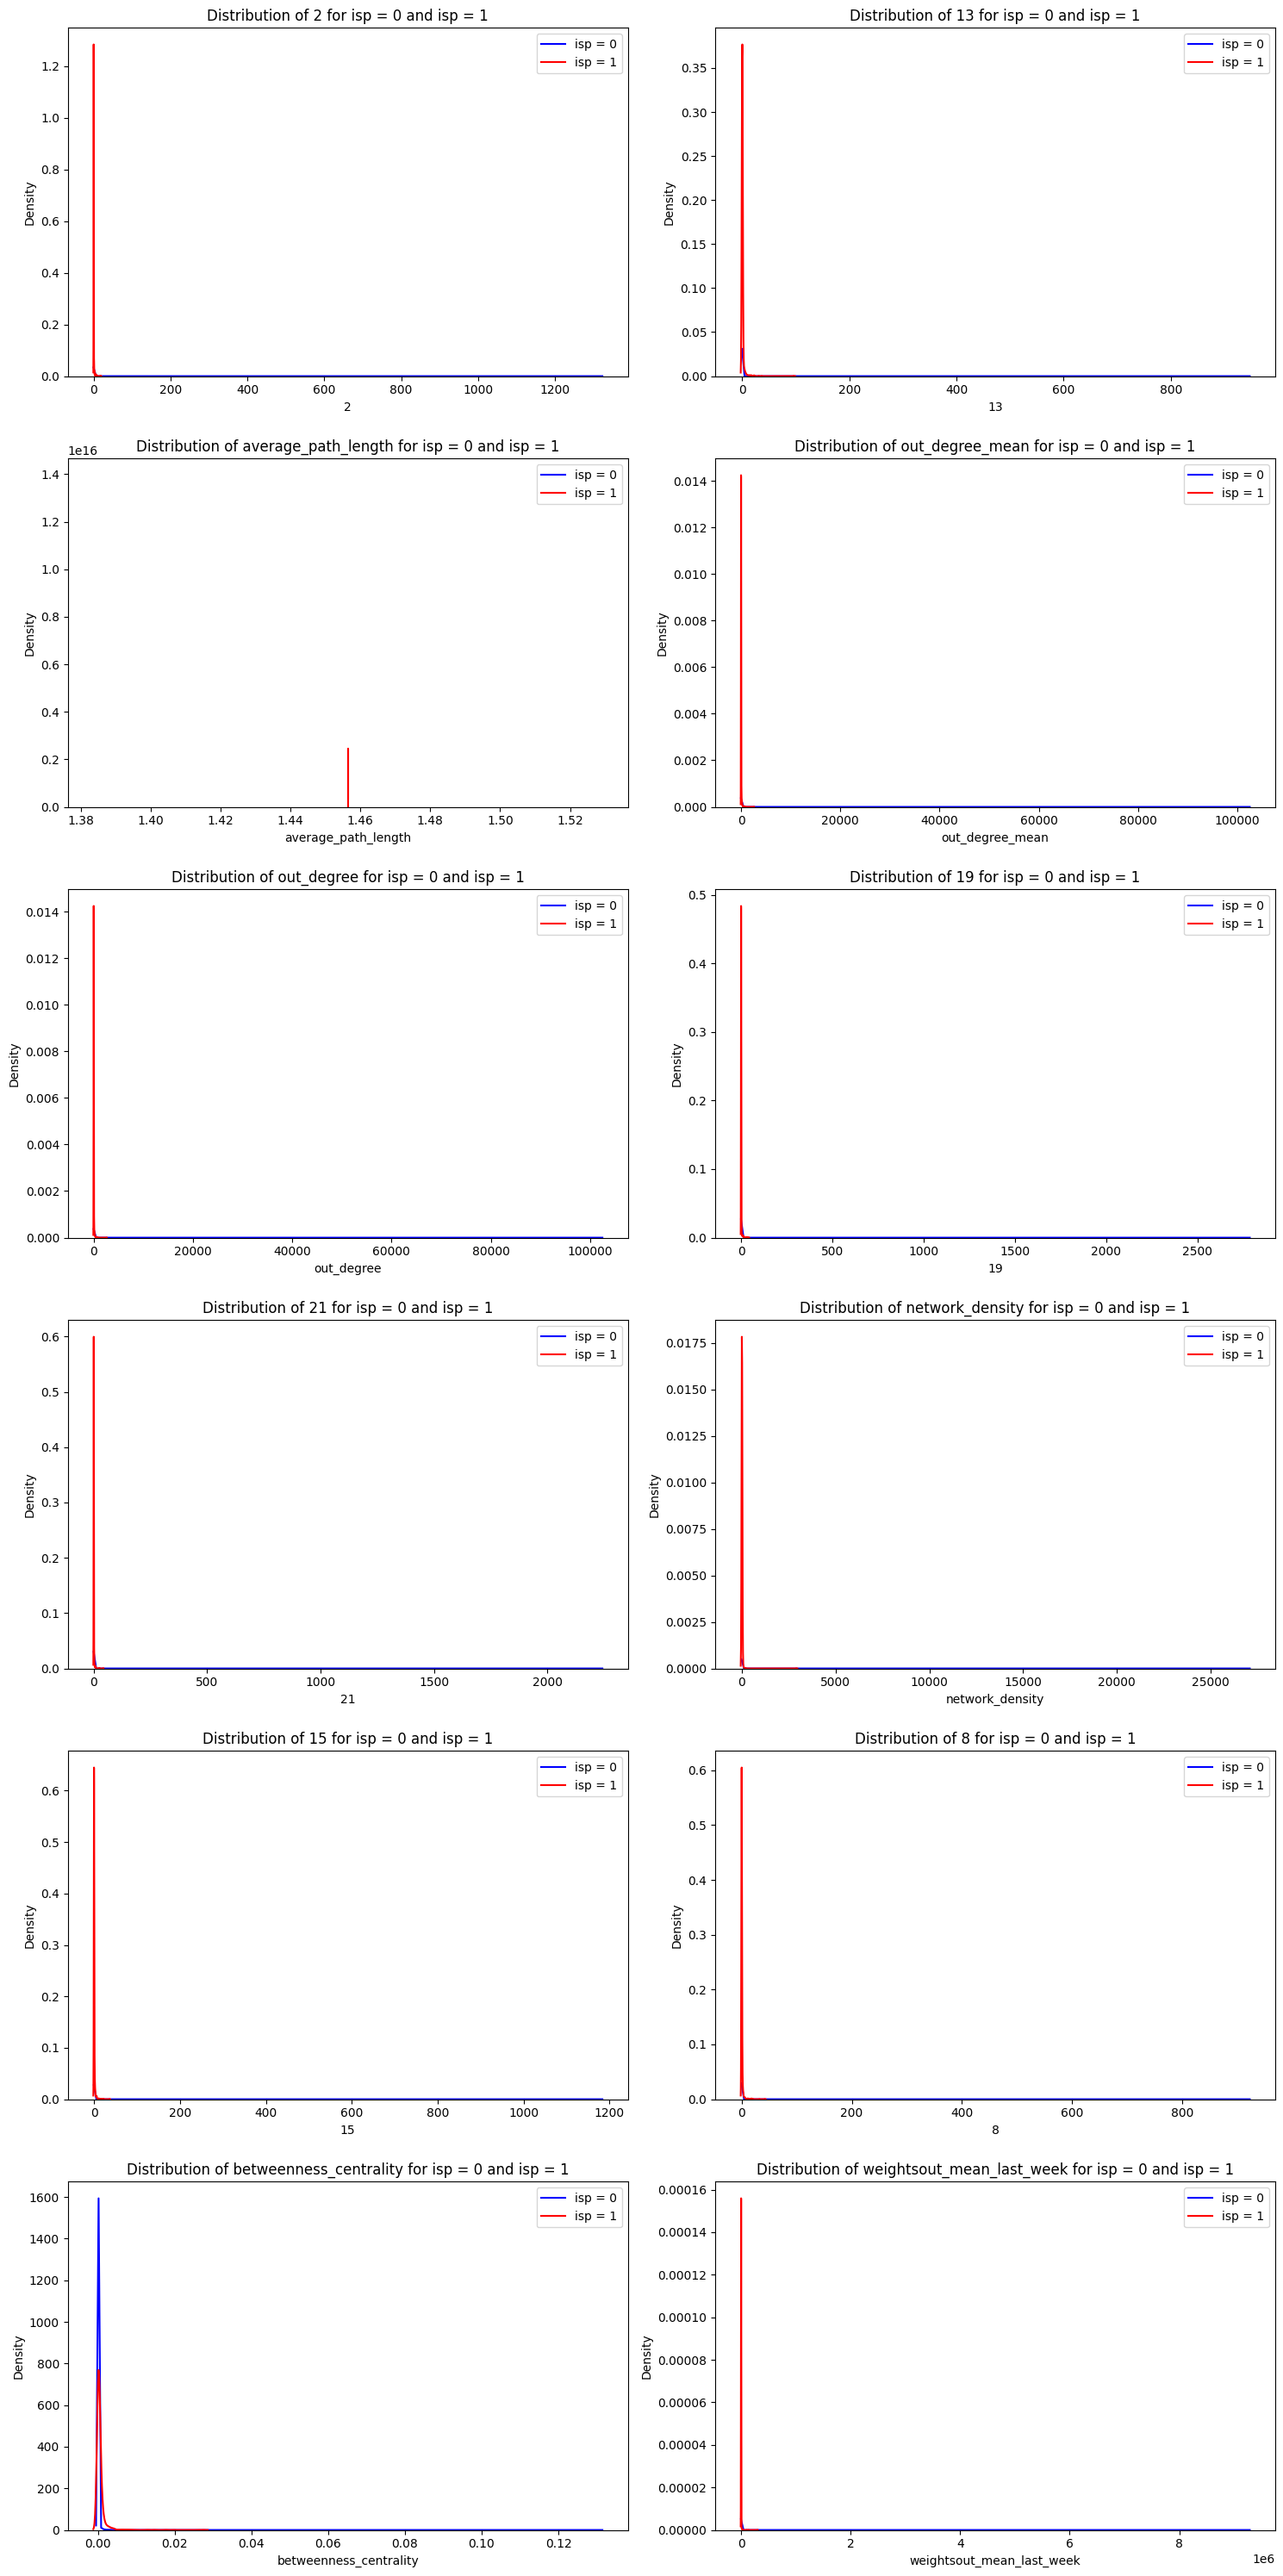

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Assuming your data is in a DataFrame named 'feature_data'

# Filter the data for 'isp' = 0 and 'isp' = 1
data_isp_0 = feature_data[feature_data['isp'] == 0]
data_isp_1 = feature_data[feature_data['isp'] == 1]


# Sample a subset of features to visualize
num_features_to_plot = 12
selected_features = np.random.choice(features, num_features_to_plot, replace=False)

num_rows = int(np.ceil(num_features_to_plot / 2))  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))  # Create subplots

for i, feature in enumerate(selected_features):
    ax = axes[i // 2, i % 2]  # Determine the current subplot
    sns.kdeplot(data=data_isp_0[feature], label='isp = 0', color='blue', ax=ax)
    sns.kdeplot(data=data_isp_1[feature], label='isp = 1', color='red', ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of {feature} for isp = 0 and isp = 1')
    ax.legend()

# Hide empty subplots if there are any
for i in range(num_features_to_plot, num_rows * 2):
    axes[i // 2, i % 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
columns = LABELS
rows = [{c:feature_data[f].corr(feature_data[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)

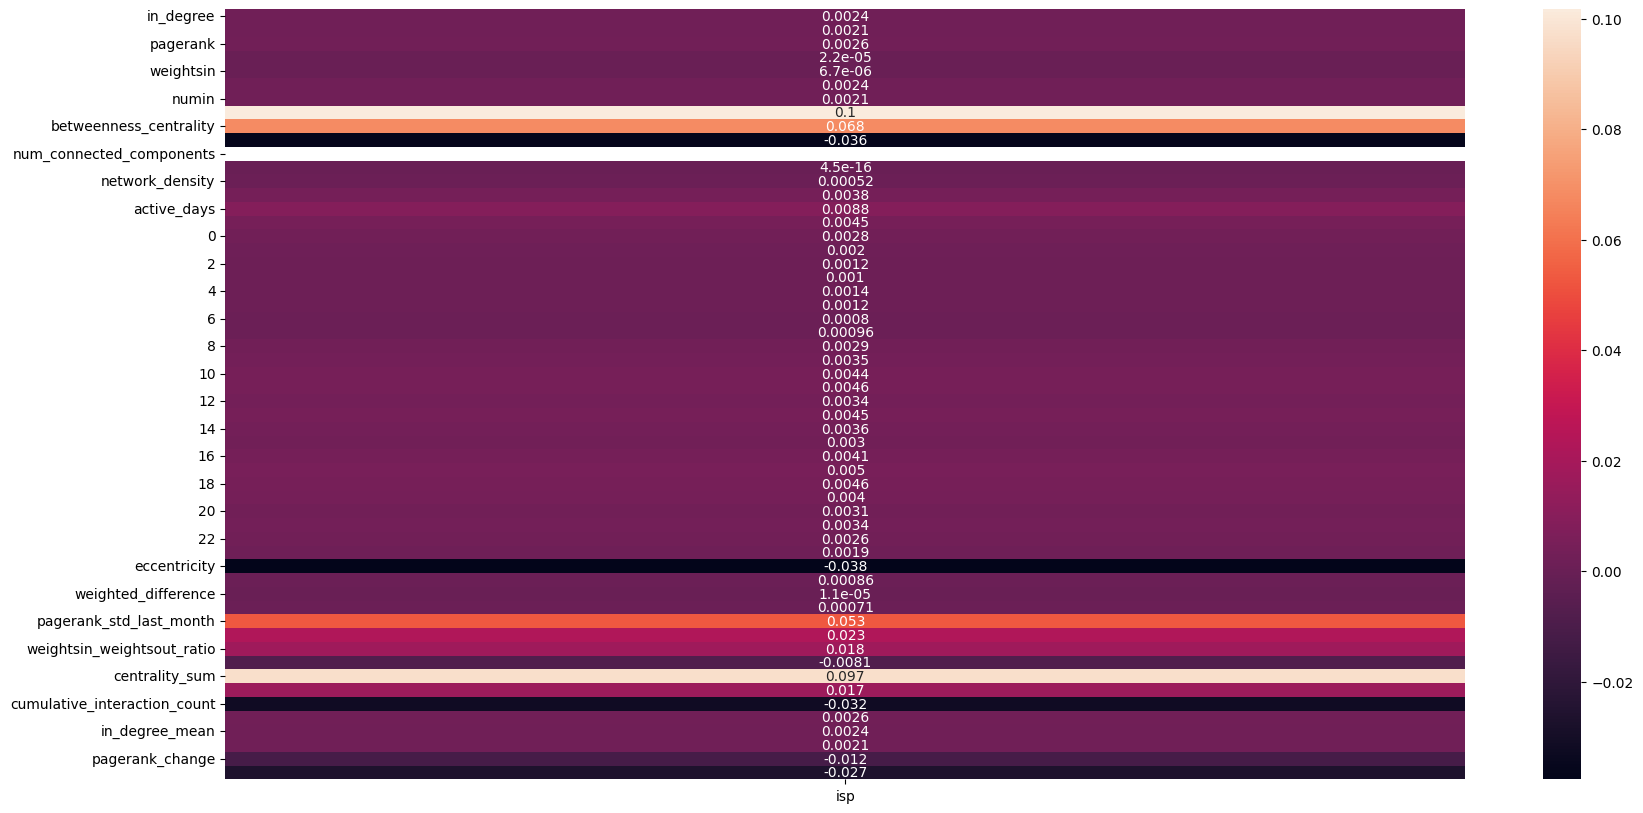

In [ ]:
plt.figure(figsize = (20,10))
sns.heatmap(train_correlations, annot=True)
plt.show()

14


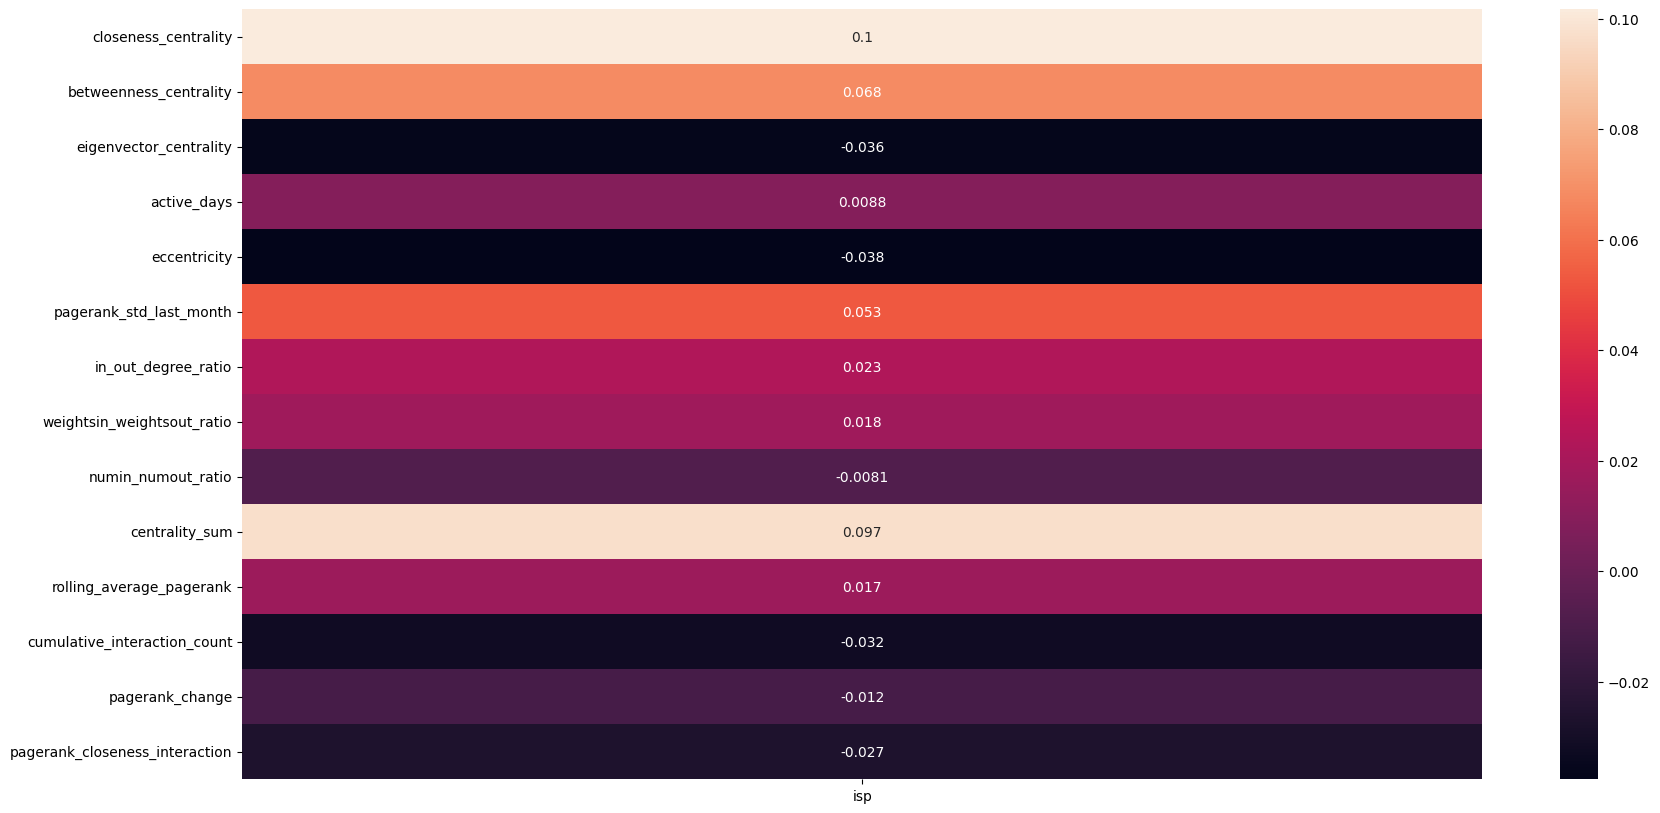

In [ ]:
masking = list(map(lambda x: abs(max(train_correlations.iloc[x], key=abs))>0.006, range(len(train_correlations))))

print(len(train_correlations[masking]))
plt.figure(figsize = (20,10))
sns.heatmap(train_correlations[masking], annot=True)
plt.show()

In [ ]:
train_correlations[masking].index

Index(['closeness_centrality', 'betweenness_centrality',
       'eigenvector_centrality', 'active_days', 'eccentricity',
       'pagerank_std_last_month', 'in_out_degree_ratio',
       'weightsin_weightsout_ratio', 'numin_numout_ratio', 'centrality_sum',
       'rolling_average_pagerank', 'cumulative_interaction_count',
       'pagerank_change', 'pagerank_closeness_interaction'],
      dtype='object')

feature importance

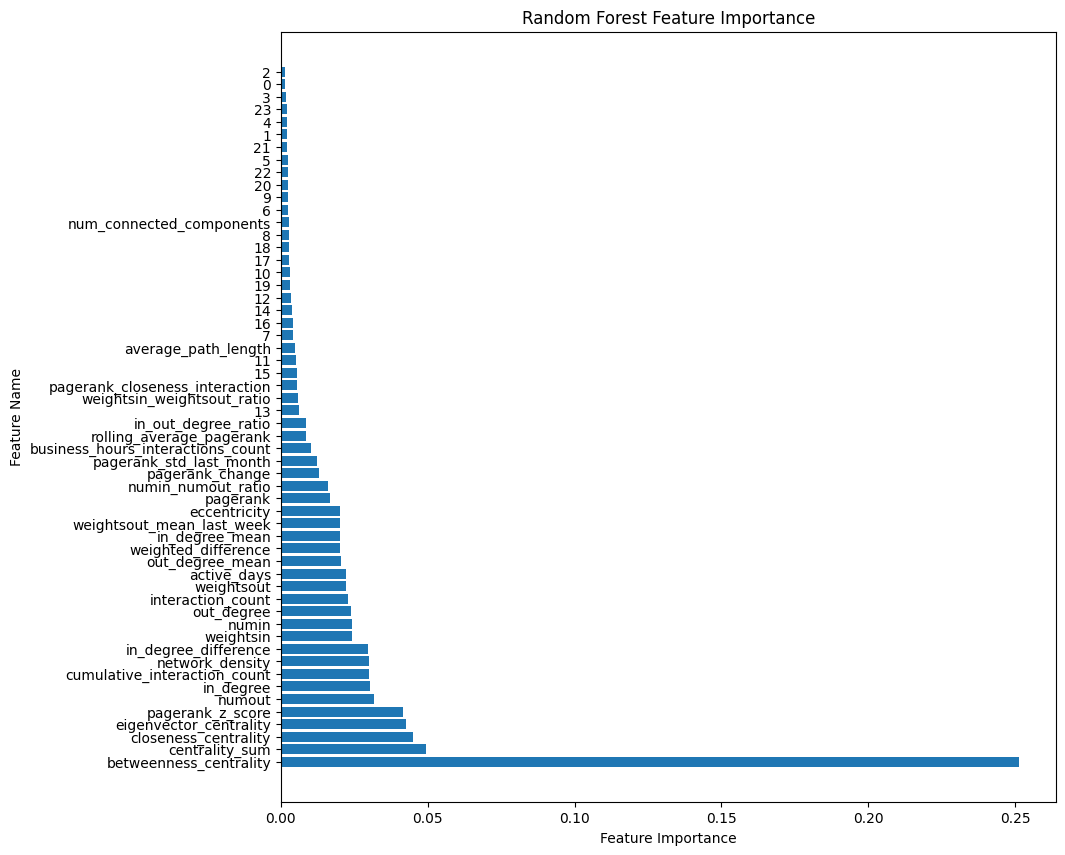

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
X = feature_data[features].fillna(0)
y = feature_data[LABELS]
# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Fit the model to your data
rf.fit(X,y)

# Get feature importances from the trained model
feature_importances = rf.feature_importances_

# Extract feature names from your DataFrame (assuming feature_data is a DataFrame)
feature_names = features  # Get the column names as feature names

# Get the indices of features sorted by their importance
sorted_indices = (-np.array(feature_importances)).argsort()

# Rearrange feature names based on importance order
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Plotting feature importances
plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_feature_names)), np.array(feature_importances)[sorted_indices], align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Random Forest Feature Importance')
plt.show()


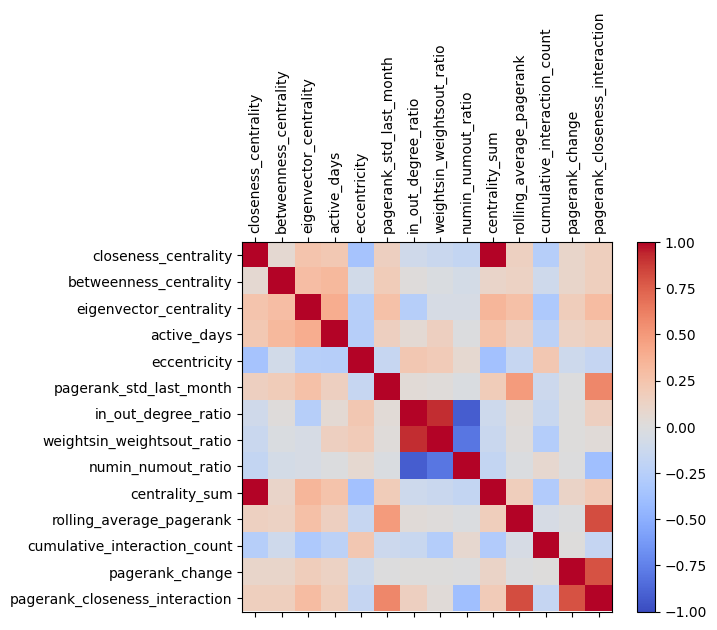

In [ ]:

features =['closeness_centrality', 'betweenness_centrality',
       'eigenvector_centrality', 'active_days', 'eccentricity',
       'pagerank_std_last_month', 'in_out_degree_ratio',
       'weightsin_weightsout_ratio', 'numin_numout_ratio', 'centrality_sum',
       'rolling_average_pagerank', 'cumulative_interaction_count',
       'pagerank_change', 'pagerank_closeness_interaction']

correlation = feature_data[features].corr()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(features),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(features)
ax.set_yticklabels(features)
plt.show()

feature importance after selection

<ipython-input-21-2f45d492606b>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X,y)


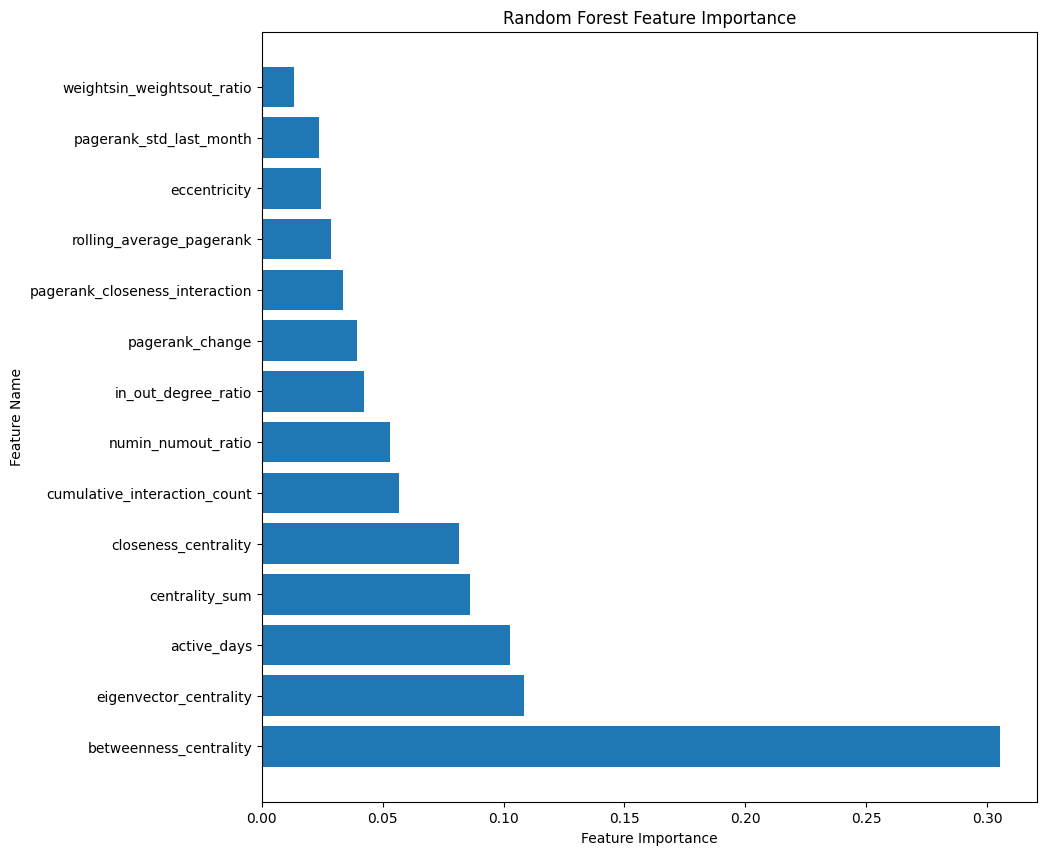

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
X = feature_data[features].fillna(0)
y = feature_data[LABELS]
# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Fit the model to your data
rf.fit(X,y)

# Get feature importances from the trained model
feature_importances = rf.feature_importances_

# Extract feature names from your DataFrame (assuming feature_data is a DataFrame)
feature_names = features  # Get the column names as feature names

# Get the indices of features sorted by their importance
sorted_indices = (-np.array(feature_importances)).argsort()

# Rearrange feature names based on importance order
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Plotting feature importances
plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_feature_names)), np.array(feature_importances)[sorted_indices], align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Random Forest Feature Importance')
plt.show()


In [ ]:
feature_data = feature_data[~pd.isnull(feature_data.closeness_centrality)]

In [ ]:
feature_data.isnull().sum()

node                                    0
isp                                     0
in_degree                               0
out_degree                              0
pagerank                                0
weightsout                              0
weightsin                               0
numout                                  0
numin                                   0
closeness_centrality                    0
betweenness_centrality                  0
eigenvector_centrality                  0
num_connected_components                0
average_path_length                     0
network_density                         0
interaction_count                    1189
active_days                          1189
business_hours_interactions_count    1189
0                                    1189
1                                    1189
2                                    1189
3                                    1189
4                                    1189
5                                 

In [ ]:
feature_data = feature_data.fillna(0)

In [ ]:
feature_data.to_csv('/content/drive/My Drive/BT4012 Team 8/Ethereum/feature_data.csv', index=False)